## MusicTransformer scripts
### Based on 2019 ICLR paper by Cheng-Zhi Anna Huang, Google Brain and Damon Gwinn's code/repo https://github.com/gwinndr/MusicTransformer-Pytorch

## Follow this repo for the terminal commands!
https://www.notion.so/callaunchpad/lofi-bytes-1aaef422367d4383886658d10c20ee0f?p=3adbc34f68664499a162fbabc1087fbe&pm=s

### Setup Environment and Dependencies

In [52]:
#@title Import all needed modules
import numpy as np
import pickle
import os
import sys
import math
import random
# For plotting
import pypianoroll
from pypianoroll import Multitrack, Track
import matplotlib
import matplotlib.pyplot as plt
import mir_eval.display
import librosa
import librosa.display
# For rendering output audio
import pretty_midi
from midi2audio import FluidSynth
# from google.colab import output
from IPython.display import display, Javascript, HTML, Audio

## Create your own Custom MIDI DataSet

In [28]:
# Create directory structure for the DataSet and prep MIDI processor
%cd ~/lofi-bytes/music-transformer/MusicTransformer-Pytorch

!mkdir 'dataset/e_piano/'
!mkdir 'dataset/e_piano/train'
!mkdir 'dataset/e_piano/test'
!mkdir 'dataset/e_piano/val'
!mkdir 'dataset/e_piano/custom_midis'

[Errno 2] No such file or directory: 'MusicTransformer-Pytorch'
/home/aliciawang/lofi-bytes/music-transformer/MusicTransformer-Pytorch
mkdir: cannot create directory ‘dataset/e_piano/’: File exists
mkdir: cannot create directory ‘dataset/e_piano/custom_midis’: File exists


### Make sure to upload your custom MIDI DataSet to created "dataset/e_piano/custom_midis" folder


For now, we are going to split the dataset by random into "test"/"val" dirs which is not ideal. So feel free to modify the code to your liking to achieve better training results with this implementation.

In [55]:
%cd ~/lofi-bytes/music-transformer/MusicTransformer-Pytorch

from processor import encode_midi

import os
import random

custom_MIDI_DataSet_dir = 'dataset/e_piano/custom_midis'

# Let's do 70% training, 15% test and 15% val
train_dir = 'dataset/e_piano/train'
test_dir = 'dataset/e_piano/test'
val_dir = 'dataset/e_piano/val'

total_count = 0
train_count = 0
val_count   = 0
test_count  = 0

f_ext = '.pickle'
fileList = os.listdir(custom_MIDI_DataSet_dir)

for file in fileList:
     # we gonna split by a random selection for now
    split = random.random()
    if (split < 0.7): # TRAINING
        o_file = os.path.join(train_dir, file+f_ext)
        train_count += 1

    elif (split >= 0.7 and split < 0.85): # VALIDATION
        o_file = os.path.join(val_dir, file+f_ext)
        val_count += 1

    elif (split >= 0.85): # TEST
        o_file = os.path.join(test_dir, file+f_ext)
        test_count += 1
    try:
        file = os.path.join(custom_MIDI_DataSet_dir, file)
        prepped = encode_midi(file)
        o_stream = open(o_file, "wb")
        pickle.dump(prepped, o_stream)
        o_stream.close()
    except KeyboardInterrupt: 
        raise   
    except:
        print('Bad file. Skipping...')

print('Done')
print("Num Train:", train_count)
print("Num Val:", val_count)
print("Num Test:", test_count)
print("Total Count:", train_count)

/home/aliciawang/lofi-bytes/music-transformer/MusicTransformer-Pytorch
Done
Num Train: 66
Num Val: 14
Num Test: 14
Total Count: 66


## Graph the results

In [31]:
#@title Graph the results
import argparse
import os
import csv
import math
import matplotlib.pyplot as plt

RESULTS_FILE = "results.csv"
EPOCH_IDX = 0
LR_IDX = 1
EVAL_LOSS_IDX = 4
EVAL_ACC_IDX = 5

SPLITTER = '?'


def graph_results(input_dirs="MusicTransformer-Pytorch/rpr/results", output_dir=None, model_names=None, epoch_start=0, epoch_end=None):
    """
    ----------
    Author: Damon Gwinn
    ----------
    Graphs model training and evaluation data
    ----------
    """

    input_dirs = input_dirs.split(SPLITTER)

    if(model_names is not None):
        model_names = model_names.split(SPLITTER)
        if(len(model_names) != len(input_dirs)):
            print("Error: len(model_names) != len(input_dirs)")
            return

    #Initialize Loss and Accuracy arrays
    loss_arrs = []
    accuracy_arrs = []
    epoch_counts = []
    lrs = []

    for input_dir in input_dirs:
        loss_arr = []
        accuracy_arr = []
        epoch_count = []
        lr_arr = []

        f = os.path.join(input_dir, RESULTS_FILE)
        with open(f, "r") as i_stream:
            reader = csv.reader(i_stream)
            next(reader)

            lines = [line for line in reader]

        if(epoch_end is None):
            epoch_end = math.inf

        epoch_start = max(epoch_start, 0)
        epoch_start = min(epoch_start, epoch_end)

        for line in lines:
            epoch = line[EPOCH_IDX]
            lr = line[LR_IDX]
            accuracy = line[EVAL_ACC_IDX]
            loss = line[EVAL_LOSS_IDX]

            if(int(epoch) >= epoch_start and int(epoch) < epoch_end):
                accuracy_arr.append(float(accuracy))
                loss_arr.append(float(loss))
                epoch_count.append(int(epoch))
                lr_arr.append(float(lr))

        loss_arrs.append(loss_arr)
        accuracy_arrs.append(accuracy_arr)
        epoch_counts.append(epoch_count)
        lrs.append(lr_arr)

    if(output_dir is not None):
        try:
            os.mkdir(output_dir)
        except OSError:
            print ("Creation of the directory %s failed" % output_dir)
        else:
            print ("Successfully created the directory %s" % output_dir)

    ##### LOSS #####
    for i in range(len(loss_arrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], loss_arrs[i], label=name)
        plt.title("Loss Results")
        plt.ylabel('Loss (Cross Entropy)')
        plt.xlabel('Epochs')
        fig1 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig1.savefig(os.path.join(output_dir, 'loss_graph.png'))

    plt.show()

    ##### ACCURACY #####
    for i in range(len(accuracy_arrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], accuracy_arrs[i], label=name)
        plt.title("Accuracy Results")
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        fig2 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig2.savefig(os.path.join(output_dir, 'accuracy_graph.png'))

    plt.show()

    ##### LR #####
    for i in range(len(lrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], lrs[i], label=name)
        plt.title("Learn Rate Results")
        plt.ylabel('Learn Rate')
        plt.xlabel('Epochs')
        fig2 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig2.savefig(os.path.join(output_dir, 'lr_graph.png'))

    plt.show()

[Errno 2] No such file or directory: 'MusicTransformer-Pytorch'
/home/aliciawang/lofi-bytes/music-transformer/MusicTransformer-Pytorch


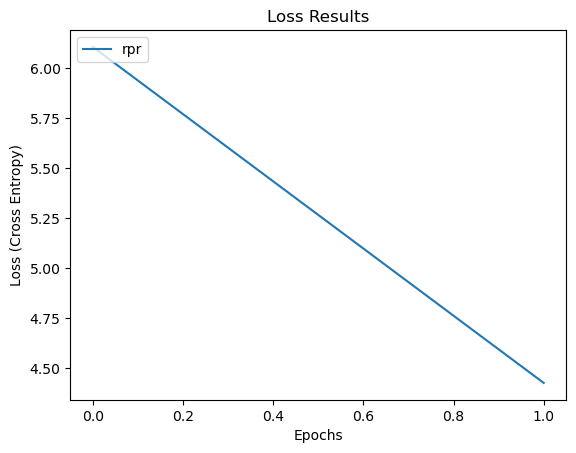

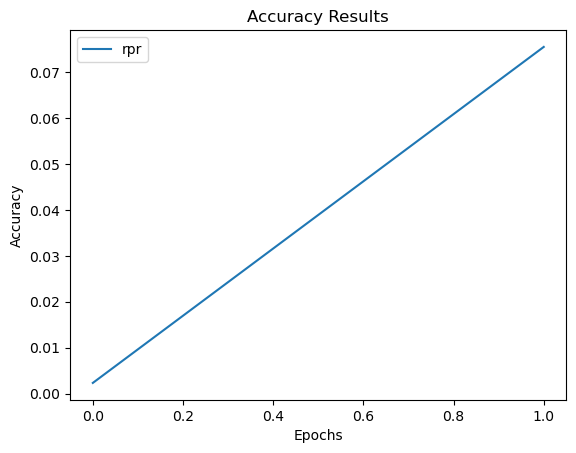

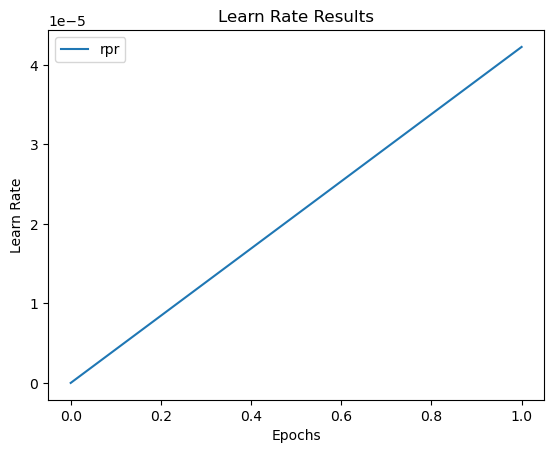

In [34]:
%cd ~/lofi-bytes/music-transformer

graph_results('model_100/results', model_names='rpr')

## Generate .wav and piano roll

In [56]:
%cd ~/lofi-bytes/music-transformer

# get some already installed sound font, or download your own
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 font.sf2

FluidSynth("font.sf2").midi_to_audio('output/rand.mid', 'output/output.wav')

/home/aliciawang/lofi-bytes/music-transformer
FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'output/output.wav'..


In [57]:
from pydub import AudioSegment
import IPython

audio_file = 'output/output.wav'

IPython.display.Audio(audio_file)

### Print piano track

In [62]:
graphs_length_inches = 18 #@param {type:"slider", min:0, max:20, step:1}
notes_graph_height = 6 #@param {type:"slider", min:0, max:20, step:1}
highest_displayed_pitch = 92 #@param {type:"slider", min:1, max:128, step:1}
lowest_displayed_pitch = 24 #@param {type:"slider", min:1, max:128, step:1}
piano_roll_color_map = "Blues"

import librosa
import numpy as np
import pretty_midi
import pypianoroll
from pypianoroll import Multitrack, Track
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('SVG')
# For plotting
import mir_eval.display
import librosa.display
%matplotlib inline


midi_data = pretty_midi.PrettyMIDI('output/rand.mid')

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

roll = np.zeros([int(graphs_length_inches), 128])
# Plot the output

# something wrong w this part but yall can figure it out <3
track = Multitrack('output/rand.mid', name='track')

plt.figure(figsize=[graphs_length_inches, notes_graph_height])
fig, ax = track.plot()
fig.set_size_inches(graphs_length_inches, notes_graph_height)
plt.figure(figsize=[graphs_length_inches, notes_graph_height])
ax2 = plot_piano_roll(midi_data, int(lowest_displayed_pitch), int(highest_displayed_pitch))
plt.show(block=False)

TypeError: __init__() got multiple values for argument 'name'